In [1]:
%matplotlib inline
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy.interpolate import interp1d
from utils import *

## NSRBD Data for Site in Year

In [2]:
SITE_IDX = 131123 # closest NSRDB site to Fort Ross (used KD tree from demo)
SITE_TIMEZONE = 'America/Los_Angeles'
DATA_YEAR = '2017'
DATA_MONTH = '06'
MONTH_FILTER = f'{DATA_YEAR}-{DATA_MONTH}'

ghi_year = get_nsrdb_data(DATA_YEAR, 'ghi', SITE_IDX, SITE_TIMEZONE)

Found cached/site-131123-data-2016.pkl, loading...


## Get Tide Predictions for Year

In [3]:
year_before = str(int(DATA_YEAR) - 1)
year_after = str(int(DATA_YEAR) + 1)
params = {
    'product': 'predictions',
    'application': 'NOS.COOPS.TAC.WL',
    'begin_date': f'{year_before}1231', # extends 1d before and after for interpolation purposes
    'end_date': f'{year_after}0101',
    'datum': 'MLLW', # is this reasonable? https://tidesandcurrents.noaa.gov/datum_options.html
    'station': '9416024',  # Fort Ross station ID
    'time_zone': 'lst_ldt',
    'units': 'english',
    'interval': 'hilo',
    'format': 'json'
}

url = 'https://api.tidesandcurrents.noaa.gov/api/prod/datagetter'
tide_api_response = requests.get(url, params=params)

### Localize and Format Tide Data

In [4]:
if tide_api_response.status_code == 200:
    tide_predictions_df = pd.DataFrame(tide_api_response.json()['predictions'])
    tide_index = pd.DatetimeIndex(tide_predictions_df['t']).tz_localize(SITE_TIMEZONE)
    tide_series = pd.Series(data=tide_predictions_df['v'].values, index=tide_index, dtype=float)
else:
    print('Failed to retrieve data:', tide_api_response.status_code)

### Reconstruct High-Res Tide with Interpolation

In [5]:
# Convert timestamps to a numeric format for interpolation
tide_timestamps_numeric = mdates.date2num(tide_series.index)
interpolator = interp1d(tide_timestamps_numeric, tide_series, kind='cubic', fill_value='extrapolate')

tide_high_res_numeric = interpolator(mdates.date2num(ghi_year.index))
tide_high_res = pd.Series(data=tide_high_res_numeric, index=ghi_year.index)

## Chart Yearly Tide(?)

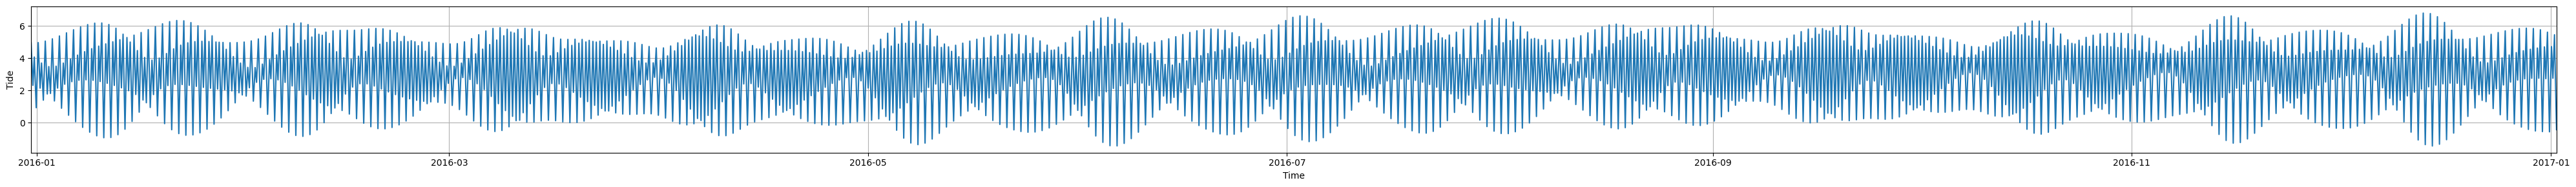

In [26]:
plt.figure(figsize=(40, 3))
# plt.plot(tide_high_res['2016-04'].index, tide_high_res['2016-04'], label='tide', color='tab:blue')
plt.plot(tide_series.index, tide_series, label='tide', color='tab:blue')
plt.xlim(tide_series.index[0], tide_series.index[-1])

# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1, tz=SITE_TIMEZONE))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=SITE_TIMEZONE))
# plt.xlim(ghi_month.index[0], ghi_month.index[-1])

# plt.fill_between(ghi_month.index, ghi_month.min(), ghi_month, color='tab:red', alpha=0.3, zorder=2)

# Set title using the first index's month and year, dynamically adjusting to the displayed data
# plt.title(f'GHI in {ghi_month.index[0].month_name()} {ghi_month.index[0].year} near Fort Ross')
plt.xlabel('Time')
plt.ylabel('Tide')

plt.grid(True)
# plt.legend()
plt.tight_layout()
plt.show()

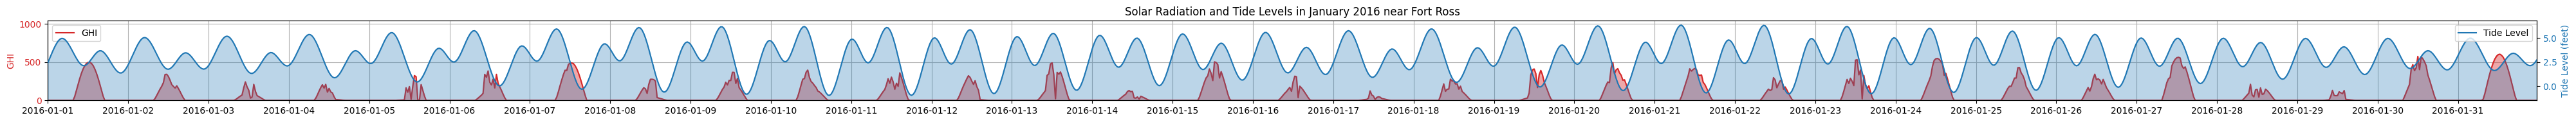

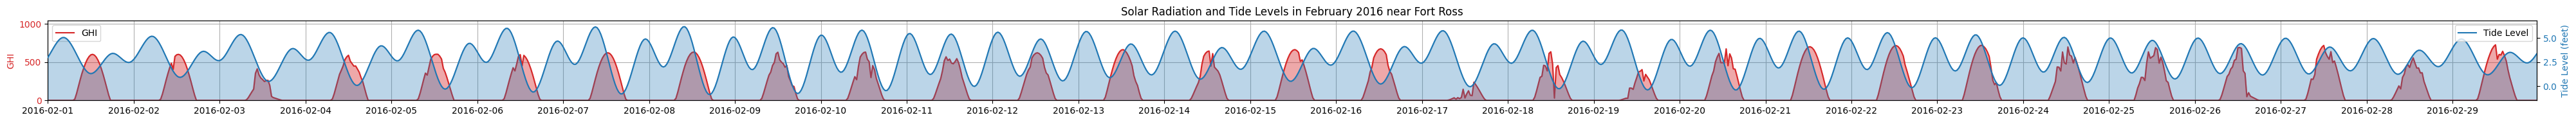

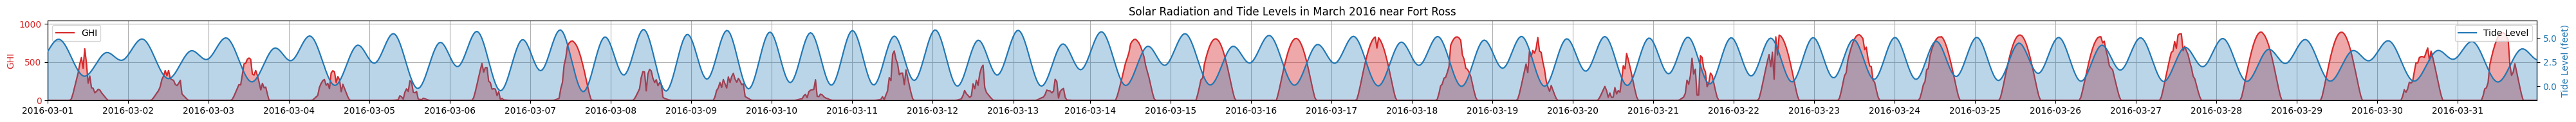

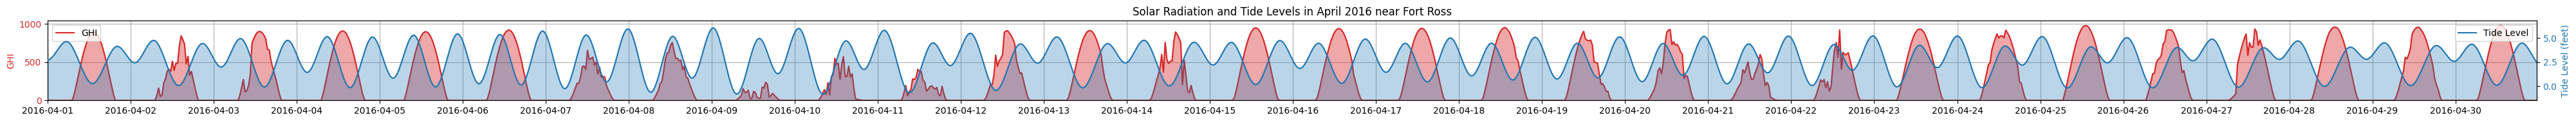

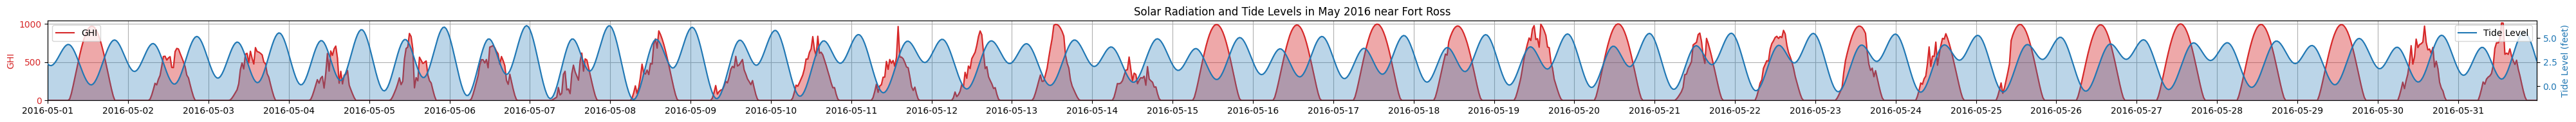

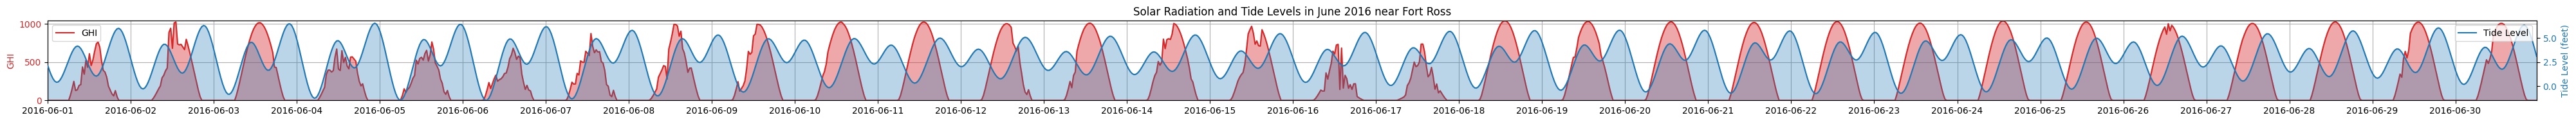

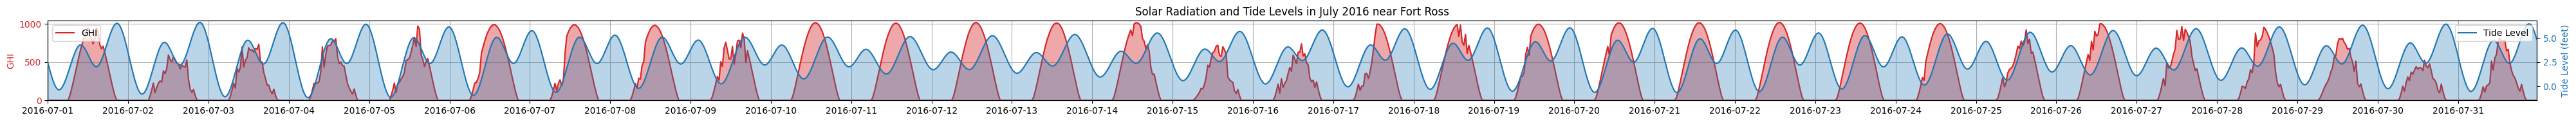

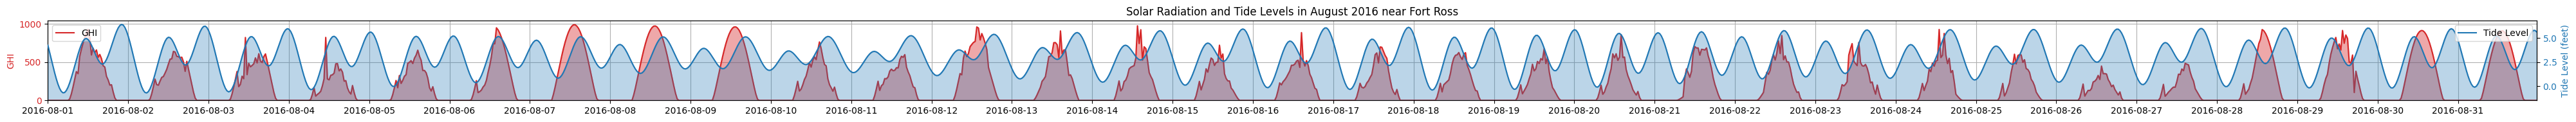

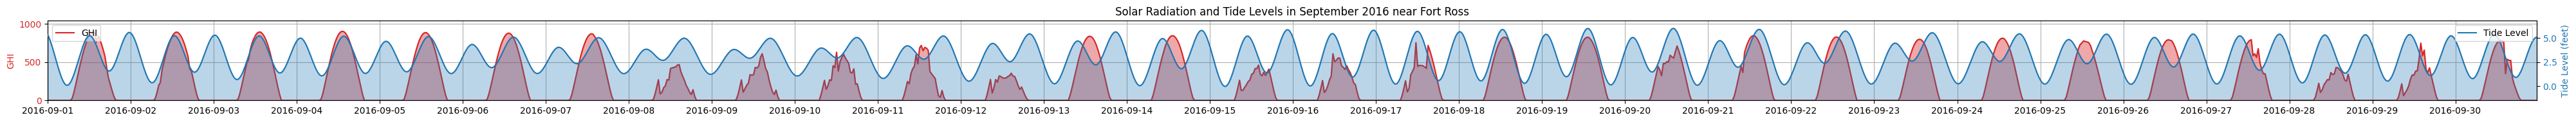

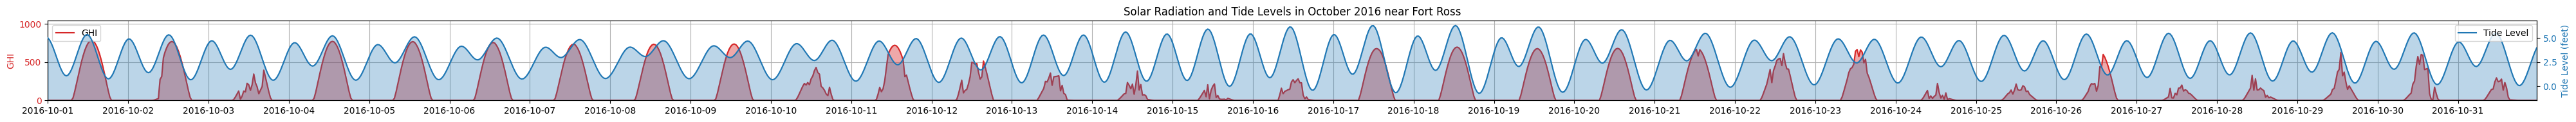

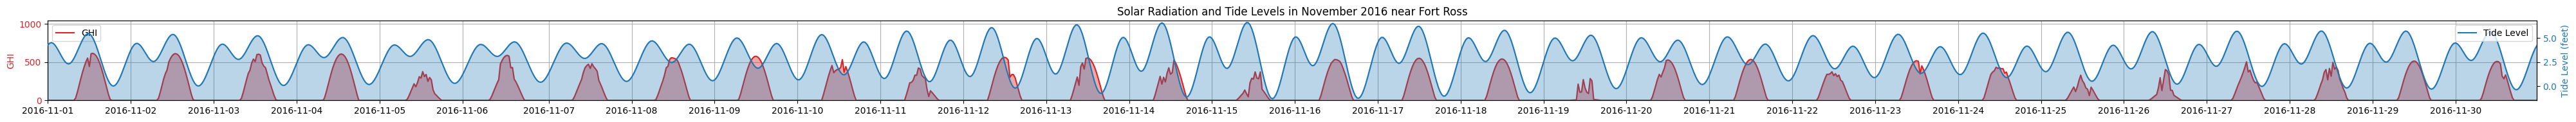

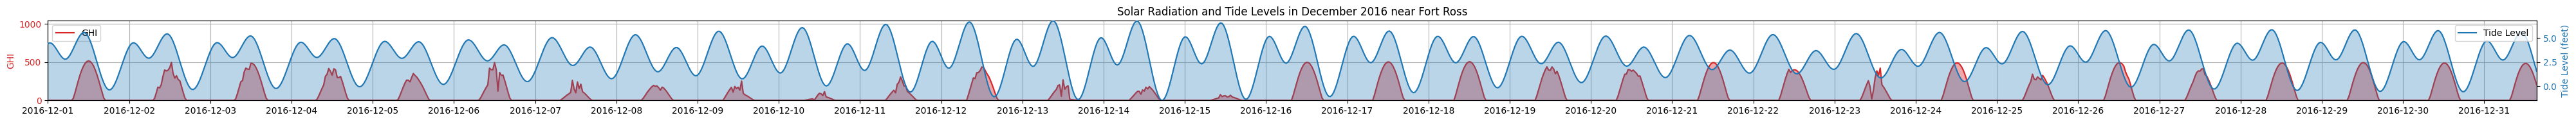

In [7]:
for month in range(1,13):
    month_mask = f'{DATA_YEAR}-{str(month).zfill(2)}'
    ghi_month = ghi_year[month_mask]
    tide_month = tide_high_res[month_mask]

    fig, ax1 = plt.subplots(figsize=(40, 2))

    # Plot GHI data
    ax1.plot(ghi_month.index, ghi_month, label='GHI', color='tab:red', zorder=3)
    ax1.xaxis.set_major_locator(mdates.DayLocator(tz=SITE_TIMEZONE))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=SITE_TIMEZONE))
    plt.xlim(ghi_month.index[0], ghi_month.index[-1])
    ax1.set_ylabel('GHI', color='tab:red')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.set_ylim([0, ghi_year.max()])

    # Shade the area below the GHI line
    ax1.fill_between(ghi_month.index, ghi_month.min(), ghi_month, color='tab:red', alpha=0.4, zorder=2)

    # Create a secondary y-axis for tide data
    ax2 = ax1.twinx()
    ax2.plot(ghi_month.index, tide_month, label='Tide Level', color='tab:blue', linestyle='-', zorder=4)
    ax2.set_ylabel('Tide Level (feet)', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.set_ylim([tide_series.min(), tide_series.max()])

    # Shade the area below the tide line
    ax2.fill_between(ghi_month.index, tide_month.min() - 2, tide_month, color='tab:blue', alpha=0.3, zorder=1)

    # Title, grid, and legend
    ax1.set_title(f"Solar Radiation and Tide Levels in {ghi_month.index[0].strftime('%B %Y')} near Fort Ross")
    ax1.grid(True)
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.show()


### Normalize Tide Data
We want to scale the solar radiation according to how low the tide was, so with our tide data currently in the range 0-1 where 0 is the lowest tide, we need to invert that so 0 is the highest tide, meaning the least solar radiation is getting absorbed.

In [8]:
min_val, max_val = tide_high_res.min(), tide_high_res.max()
tide_values_normalized = (tide_high_res - min_val) / (max_val - min_val)

## Graph Tide-Thresholded Radiation

In [9]:
TIDE_THRESHOLD = 0.50 # TODO where should this be from??
tide_thresholded_ghi = ghi_year * (tide_values_normalized < TIDE_THRESHOLD)

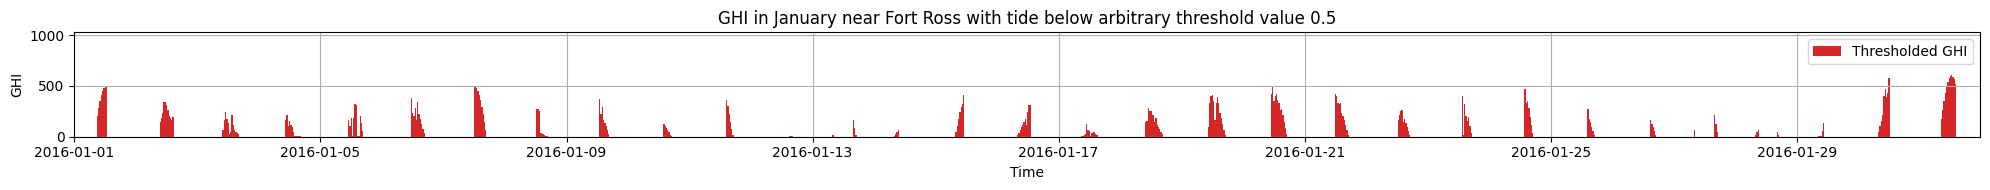

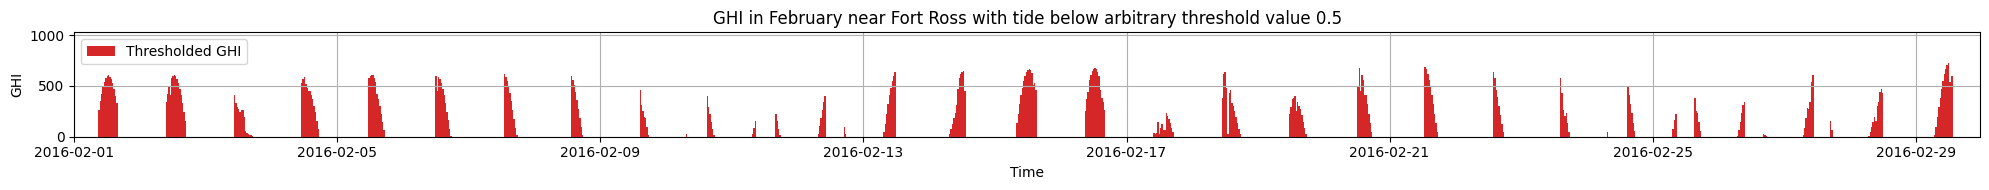

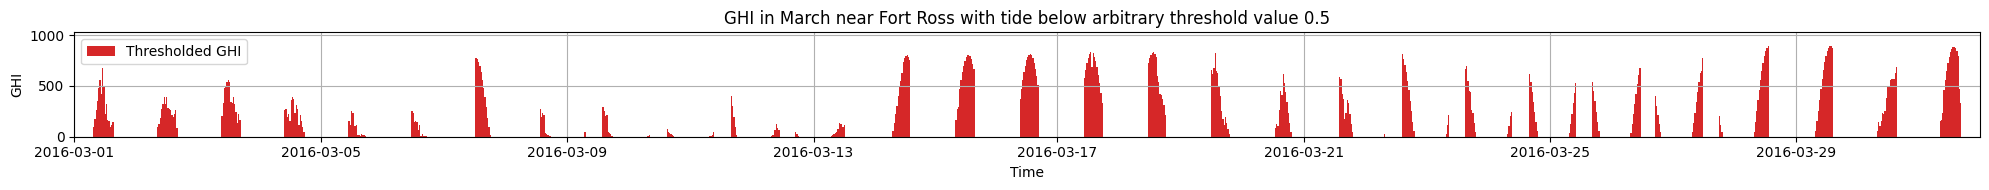

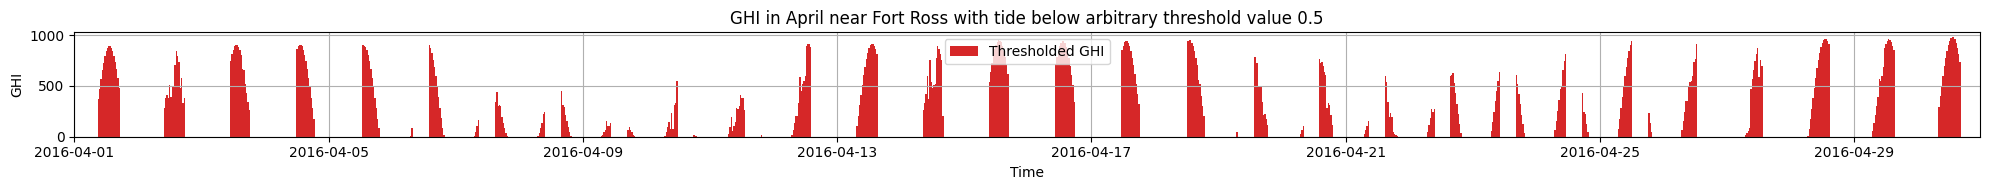

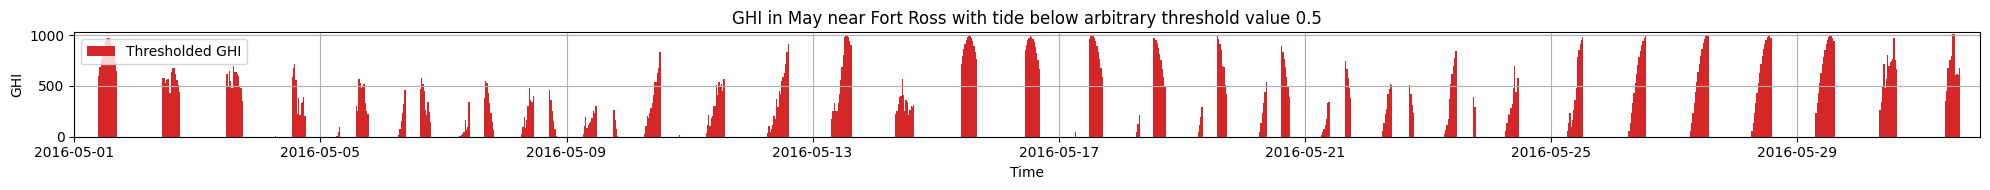

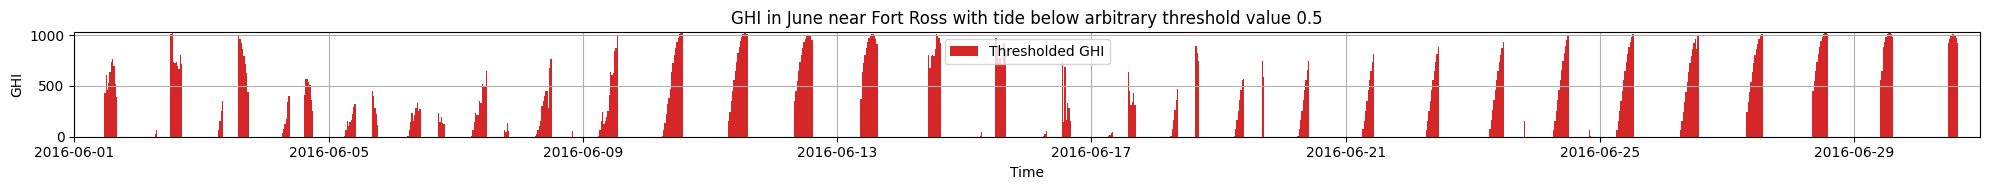

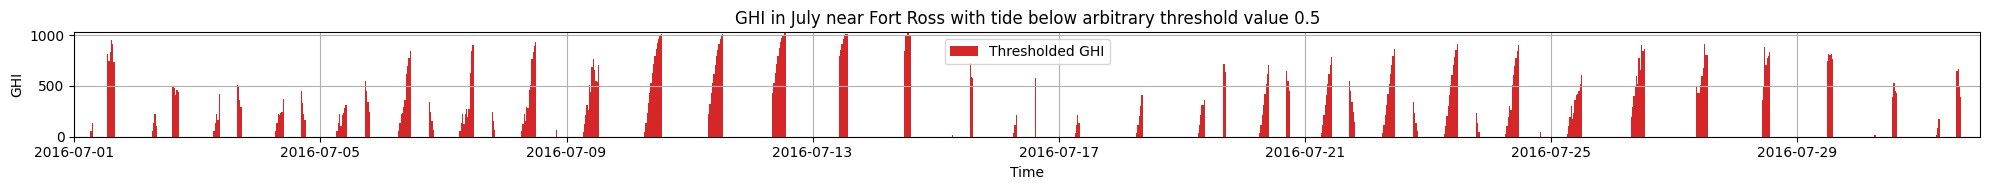

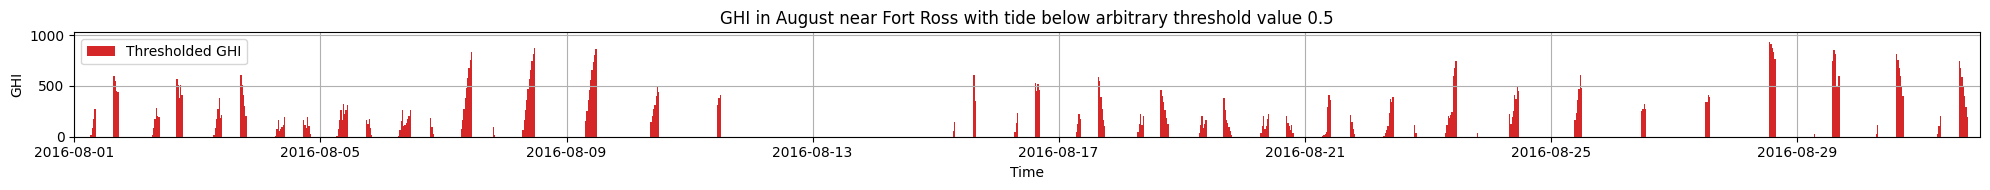

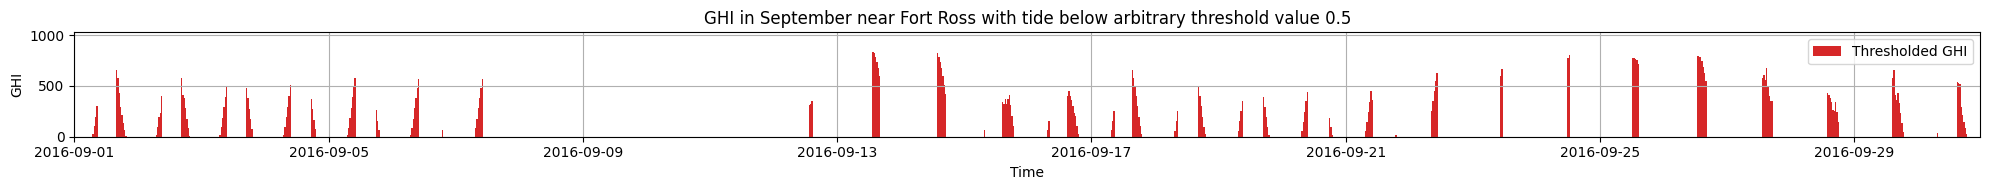

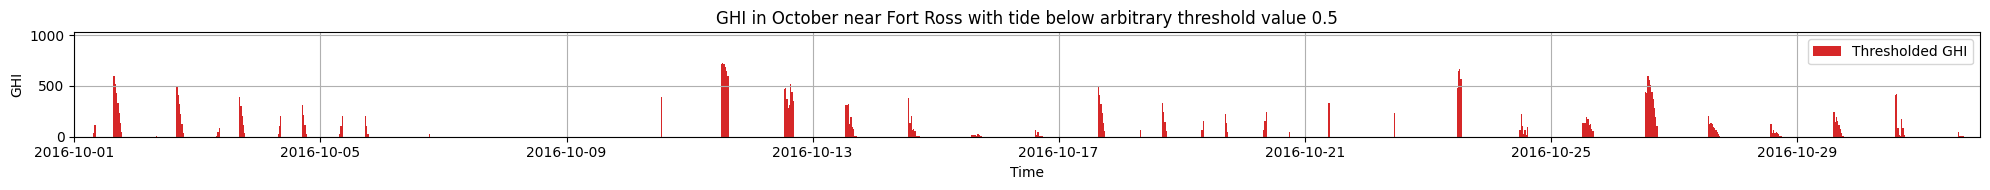

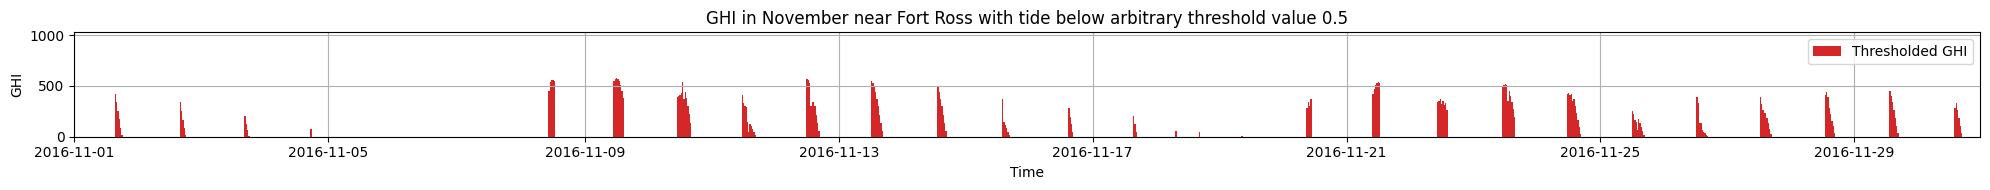

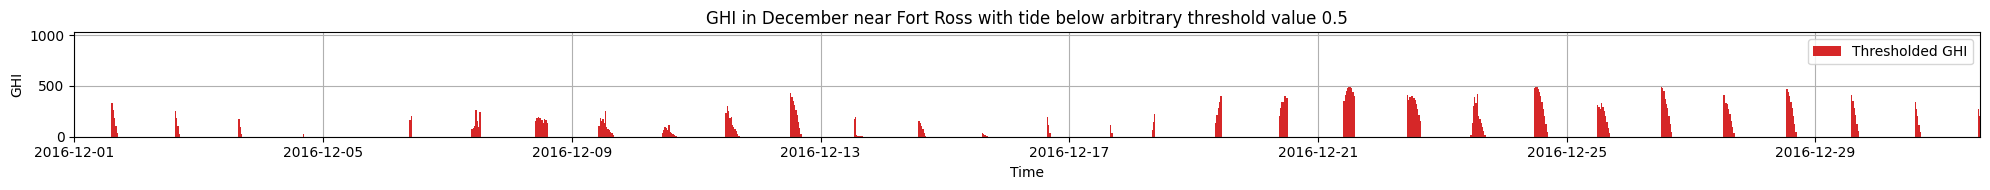

In [10]:
for month in range(1,13):
    month_mask = f'{DATA_YEAR}-{str(month).zfill(2)}'
    ghi_month = ghi_year[month_mask]
    tide_thresholded_month = tide_thresholded_ghi[month_mask]

    plt.figure(figsize=(20, 2))

    # Calculating the width of each bar in days (assuming regular intervals)
    if len(ghi_month.index) > 1:
        bar_width = (ghi_month.index[1] - ghi_month.index[0]).total_seconds() / (24 * 3600)
    else:
        bar_width = 0.01  # default to a very small width if unable to calculate

    plt.bar(ghi_month.index, tide_thresholded_month, width=bar_width, color='tab:red', label='Thresholded GHI', align='center')

    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(tz=SITE_TIMEZONE))
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d', tz=SITE_TIMEZONE))
    plt.xlim(ghi_month.index[0], ghi_month.index[-1])
    plt.ylim(0, tide_thresholded_ghi.max())

    plt.title(f'GHI in {ghi_month.index[0].month_name()} near Fort Ross with tide below arbitrary threshold value {TIDE_THRESHOLD}')
    plt.xlabel('Time')
    # plt.xticks(rotation=45)
    plt.ylabel('GHI')

    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Aggregate by Days
TODO: Dates are off in the labels for some reason

In [11]:
DATA_GRANULARITY = 48 # 48 measurements per day; twice hourly

def aggregate_data(data_series):
    total_measurements = data_series.size
    if total_measurements % DATA_GRANULARITY != 0:
        raise ValueError("The number of measurements is not consistent with whole days")
    num_days = total_measurements // DATA_GRANULARITY

    reshaped_data = data_series.values.reshape((num_days, DATA_GRANULARITY))
    return np.sum(reshaped_data, axis=1)

daily_tide_thresholded_ghi = aggregate_data(tide_thresholded_ghi)

In [19]:
len(daily_tide_thresholded_ghi)

366

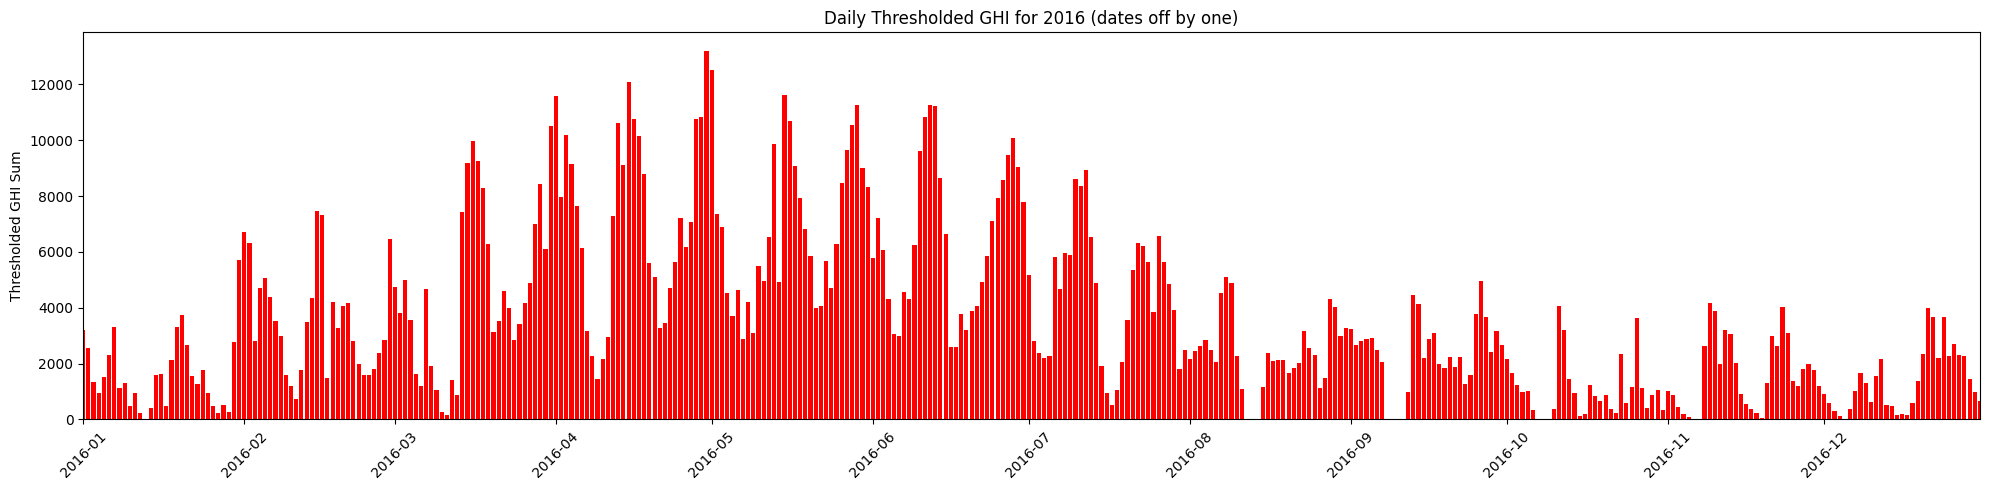

In [24]:
# Generate a date range for the month
plot_date_range = pd.date_range(start=f"{DATA_YEAR}-01-01", periods=len(daily_tide_thresholded_ghi), freq='D', tz=SITE_TIMEZONE)

# Create the plot
plt.figure(figsize=(20, 5))  # Adjust the figure size as needed
plt.bar(plot_date_range, daily_tide_thresholded_ghi, color='red')
plt.xlim(plot_date_range[0], plot_date_range[-1])

plt.title(f'Daily Thresholded GHI for {plot_date_range[0].strftime("%Y")} (dates off by one)')
plt.ylabel('Thresholded GHI Sum')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()